## VAR model ver 1
using actual shortlisted variables

In [1]:
# Import libraries
import numpy as np 
import pandas as pd 
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.eval_measures import rmse, aic

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read csv
file_path = '../data/final/wo_na.csv'
df = pd.read_csv(file_path)

In [3]:
df.head()

,Date,"HRC (FOB, $/t)","Iron Ore (CFR, $/t)","HCC (Aus FOB, $/t)",Domestic Scrap (DDP Jiangsu incl. VAT $/t),HRC - RM Spread ($/t),Monthly Export of Semis & Finished Steel as % of Production,FAI in urban real estate development (y-o-y) Growth,Automobile Production (y-o-y),Civil Metal-Vessels/Steel Ships (y-o-y),Household Fridges (y-o-y),Air Conditioner (y-o-y)
0,2006-09-01,472,59,116,252,261,14.277778,24.3,24.0,6.0,34.2,3.9
1,2006-10-01,477,62,85,260,292,13.657895,24.1,25.1,11.4,31.8,6.7
2,2006-11-01,470,62,84,262,288,16.078947,24.0,26.1,8.3,28.9,7.2
3,2006-12-01,470,61,90,270,282,15.512821,21.8,27.0,13.1,15.8,16.1
4,2007-01-01,470,62,98,273,273,13.026316,24.3,45.0,8.6,15.8,16.1


In [4]:
df.columns.values

array(['Date', 'HRC (FOB, $/t)', 'Iron Ore (CFR, $/t)',
       'HCC (Aus FOB, $/t)', 'Domestic Scrap (DDP Jiangsu incl. VAT $/t)',
       'HRC - RM Spread ($/t)',
       'Monthly Export of Semis & Finished Steel as % of Production',
       'FAI in urban real estate development (y-o-y) Growth',
       'Automobile Production (y-o-y)',
       'Civil Metal-Vessels/Steel Ships (y-o-y)',
       'Household Fridges (y-o-y)', 'Air Conditioner (y-o-y)'],
      dtype=object)

In [5]:
final_df = df.copy()
final_df.set_index('Date', inplace=True)

final_df.head()

,"HRC (FOB, $/t)","Iron Ore (CFR, $/t)","HCC (Aus FOB, $/t)",Domestic Scrap (DDP Jiangsu incl. VAT $/t),HRC - RM Spread ($/t),Monthly Export of Semis & Finished Steel as % of Production,FAI in urban real estate development (y-o-y) Growth,Automobile Production (y-o-y),Civil Metal-Vessels/Steel Ships (y-o-y),Household Fridges (y-o-y),Air Conditioner (y-o-y)
Date,,,,,,,,,,,
2006-09-01,472,59,116,252,261,14.277778,24.3,24.0,6.0,34.2,3.9
2006-10-01,477,62,85,260,292,13.657895,24.1,25.1,11.4,31.8,6.7
2006-11-01,470,62,84,262,288,16.078947,24.0,26.1,8.3,28.9,7.2
2006-12-01,470,61,90,270,282,15.512821,21.8,27.0,13.1,15.8,16.1
2007-01-01,470,62,98,273,273,13.026316,24.3,45.0,8.6,15.8,16.1


In [6]:
# Split dataset into train and test set
final_df_train, final_df_test = final_df[0:-17], final_df[-17:]

print(final_df_train.shape)
print(final_df_test.shape)

(201, 11)
(17, 11)


In [7]:
# Difference data to achieve stationarity
final_df_train_differenced = final_df_train.diff().dropna()

In [8]:
# Determine the best number of lags
model = VAR(final_df_train_differenced)
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,44.92,45.11*,3.221e+19,45.00*
1,44.55,46.82,2.224e+19*,45.47
2,44.62,48.98,2.429e+19,46.39
3,44.79,51.22,2.948e+19,47.39
4,44.93,53.45,3.617e+19,48.38
5,45.09,55.70,4.699e+19,49.39
6,45.24,57.92,6.348e+19,50.38
7,45.55,60.32,1.086e+20,51.53
8,45.62,62.47,1.601e+20,52.45
9,45.55,64.49,2.317e+20,53.22


In [9]:
# Use lag with the lowest AIC
model_fitted = model.fit(4)
model_fitted.summary()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, Mar, 2025
Time:                     11:11:04
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                    52.9901
Nobs:                     196.000    HQIC:                   48.0629
Log likelihood:          -6945.93    FPE:                2.86833e+19
AIC:                      44.7112    Det(Omega_mle):     2.95297e+18
--------------------------------------------------------------------
Results for equation HRC (FOB, $/t)
                                                                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------------------------------------
const                                                                  0.722767         1.883469            0.384  

In [10]:
# Test if there is any serial correlation in the residuals using the Durbin Watson's Statistic.
# Significant correlation may imply that some pattern in the time series has yet to be captured and may
# require more variables to be included / using a different lag order / using a different model.
# A Durbin Watson value close to 2 implies no significant serial correlation. Values closer to 0 and 4 imply
# positive and negative serial correlation respectively.

out = durbin_watson(model_fitted.resid)

for col, val in zip(final_df.columns, out):
    print(col, ':', round(val, 2))

HRC (FOB, $/t) : 2.01
Iron Ore (CFR, $/t) : 2.01
HCC (Aus FOB, $/t) : 2.02
Domestic Scrap (DDP Jiangsu incl. VAT $/t) : 2.06
HRC - RM Spread ($/t) : 2.05
Monthly Export of Semis & Finished Steel as % of Production : 2.02
FAI in urban real estate development (y-o-y) Growth : 1.94
Automobile Production (y-o-y) : 1.92
Civil Metal-Vessels/Steel Ships (y-o-y) : 2.0
Household Fridges (y-o-y) : 1.98
Air Conditioner (y-o-y) : 1.98


In [11]:
# Using the last _ observations (since lag order is _) to forecast the following periods
lag_order = model_fitted.k_ar
forecast_input = final_df_train_differenced.values[-lag_order:]
forecast_input

array([[ 25.        ,   3.        ,  51.        ,   3.        ,
        -32.        ,  -4.57136237,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [ 19.        ,   1.        , -24.        ,  -1.        ,
         42.        ,  -1.89663462,  -0.1       ,   8.9       ,
         14.        ,   0.5       ,   1.8       ],
       [-43.        , -11.        , -76.        , -25.        ,
         50.        ,   0.30813172,  -0.4       ,   9.4       ,
          8.4       ,   2.6       ,  -0.4       ],
       [-62.        , -11.        , -38.        , -37.        ,
         -5.        ,   0.76200717,  -1.        ,   2.8       ,
         -5.        ,   1.4       ,   2.        ]])

In [12]:
# Forecast the following 12 periods (length of test set)
fc = model_fitted.forecast(y=forecast_input, steps=34)
fc_period = pd.date_range(start='6/1/2023', end='3/1/2026', freq='MS')
df_forecast = pd.DataFrame(fc, index=fc_period, columns=final_df_test.columns + '_1d')
df_forecast

,"HRC (FOB, $/t)_1d","Iron Ore (CFR, $/t)_1d","HCC (Aus FOB, $/t)_1d",Domestic Scrap (DDP Jiangsu incl. VAT $/t)_1d,HRC - RM Spread ($/t)_1d,Monthly Export of Semis & Finished Steel as % of Production_1d,FAI in urban real estate development (y-o-y) Growth_1d,Automobile Production (y-o-y)_1d,Civil Metal-Vessels/Steel Ships (y-o-y)_1d,Household Fridges (y-o-y)_1d,Air Conditioner (y-o-y)_1d
2023-06-01,-35.425380,-3.484265,-36.250689,-14.088008,6.237831,0.749509,-2.508744,-9.100629,2.547598,-4.392968,-3.053932
2023-07-01,-22.454420,-6.036012,-2.596602,-21.788676,-10.716801,-1.204150,-0.555078,1.763819,-2.351399,-2.254710,-2.439564
2023-08-01,-5.706459,-0.174383,-2.885317,-2.037029,-2.659333,-0.764934,0.572359,2.514436,-2.676840,1.747492,-1.028227
2023-09-01,-10.500218,1.560930,7.143923,6.058913,-20.032629,-0.248226,-0.480415,-0.231161,0.317491,1.407351,0.688903
2023-10-01,6.359750,0.725088,5.459193,8.543832,-0.363323,0.145819,-0.612449,0.061182,-0.727611,-0.148614,0.435318
2023-11-01,16.053229,2.921753,2.449149,8.544020,8.950915,-0.098237,-0.895291,0.633501,0.869509,0.439683,-0.379554
2023-12-01,11.321460,2.845011,7.473856,1.324073,-0.616158,0.022513,0.040152,0.801261,1.165818,0.617459,0.403534
2024-01-01,2.511016,1.764292,1.925803,-0.014025,-2.282401,0.082855,0.198536,-1.161899,1.509184,-0.055530,0.248034
2024-02-01,-2.488260,-0.159523,0.041591,-0.862881,-2.325721,0.038076,-0.043836,-0.215577,-0.314043,-0.584753,0.207721
2024-03-01,-0.900500,0.457424,-3.162591,-0.319611,1.608975,0.057629,-0.095746,-0.602527,-0.758569,-0.215638,-0.129097


In [13]:
# De-difference forecasted results
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_forecast_processed = invert_transformation(final_df_train, df_forecast)
df_forecast_processed


,"HRC (FOB, $/t)_1d","Iron Ore (CFR, $/t)_1d","HCC (Aus FOB, $/t)_1d",Domestic Scrap (DDP Jiangsu incl. VAT $/t)_1d,HRC - RM Spread ($/t)_1d,Monthly Export of Semis & Finished Steel as % of Production_1d,FAI in urban real estate development (y-o-y) Growth_1d,Automobile Production (y-o-y)_1d,Civil Metal-Vessels/Steel Ships (y-o-y)_1d,Household Fridges (y-o-y)_1d,...,"Iron Ore (CFR, $/t)_forecast","HCC (Aus FOB, $/t)_forecast",Domestic Scrap (DDP Jiangsu incl. VAT $/t)_forecast,HRC - RM Spread ($/t)_forecast,Monthly Export of Semis & Finished Steel as % of Production_forecast,FAI in urban real estate development (y-o-y) Growth_forecast,Automobile Production (y-o-y)_forecast,Civil Metal-Vessels/Steel Ships (y-o-y)_forecast,Household Fridges (y-o-y)_forecast,Air Conditioner (y-o-y)_forecast
2023-06-01,-35.425380,-3.484265,-36.250689,-14.088008,6.237831,0.749509,-2.508744,-9.100629,2.547598,-4.392968,...,101.515735,194.749311,385.911992,169.237831,10.038398,-9.708744,-2.000629,-1.952402,8.007032,11.146068
2023-07-01,-22.454420,-6.036012,-2.596602,-21.788676,-10.716801,-1.204150,-0.555078,1.763819,-2.351399,-2.254710,...,95.479724,192.152709,364.123316,158.521030,8.834248,-10.263822,-0.236809,-4.303801,5.752322,8.706504
2023-08-01,-5.706459,-0.174383,-2.885317,-2.037029,-2.659333,-0.764934,0.572359,2.514436,-2.676840,1.747492,...,95.305341,189.267393,362.086287,155.861697,8.069314,-9.691462,2.277626,-6.980641,7.499814,7.678277
2023-09-01,-10.500218,1.560930,7.143923,6.058913,-20.032629,-0.248226,-0.480415,-0.231161,0.317491,1.407351,...,96.866270,196.411316,368.145200,135.829068,7.821088,-10.171877,2.046466,-6.663150,8.907165,8.367180
2023-10-01,6.359750,0.725088,5.459193,8.543832,-0.363323,0.145819,-0.612449,0.061182,-0.727611,-0.148614,...,97.591359,201.870509,376.689032,135.465745,7.966907,-10.784327,2.107647,-7.390761,8.758552,8.802498
2023-11-01,16.053229,2.921753,2.449149,8.544020,8.950915,-0.098237,-0.895291,0.633501,0.869509,0.439683,...,100.513112,204.319658,385.233052,144.416660,7.868670,-11.679618,2.741148,-6.521252,9.198235,8.422944
2023-12-01,11.321460,2.845011,7.473856,1.324073,-0.616158,0.022513,0.040152,0.801261,1.165818,0.617459,...,103.358123,211.793514,386.557125,143.800501,7.891183,-11.639466,3.542409,-5.355434,9.815694,8.826479
2024-01-01,2.511016,1.764292,1.925803,-0.014025,-2.282401,0.082855,0.198536,-1.161899,1.509184,-0.055530,...,105.122415,213.719317,386.543100,141.518100,7.974039,-11.440930,2.380510,-3.846251,9.760165,9.074513
2024-02-01,-2.488260,-0.159523,0.041591,-0.862881,-2.325721,0.038076,-0.043836,-0.215577,-0.314043,-0.584753,...,104.962892,213.760908,385.680219,139.192379,8.012115,-11.484766,2.164933,-4.160294,9.175411,9.282234
2024-03-01,-0.900500,0.457424,-3.162591,-0.319611,1.608975,0.057629,-0.095746,-0.602527,-0.758569,-0.215638,...,105.420315,210.598318,385.360609,140.801354,8.069744,-11.580511,1.562406,-4.918862,8.959773,9.153137


In [14]:
df_forecast1, df_forecast2 = df_forecast_processed[0:-17], df_forecast_processed[-17:]
final_df.index = pd.to_datetime(final_df.index)
final_df_train.index = pd.to_datetime(final_df_train.index)
final_df_test.index = pd.to_datetime(final_df_test.index)

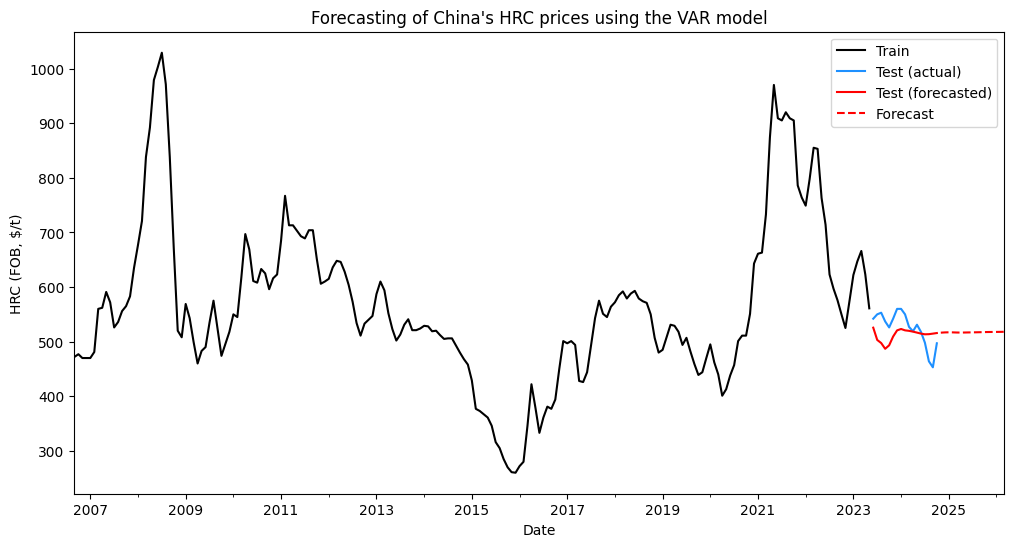

In [15]:
# Compare forecasted with actual results
fig, ax = plt.subplots(figsize=(12, 6))

final_df_train['HRC (FOB, $/t)'].plot(color='k', label='Train')
final_df_test['HRC (FOB, $/t)'].plot(color='dodgerblue', label='Test (actual)')
df_forecast1['HRC (FOB, $/t)_forecast'].plot(color='r', label='Test (forecasted)')
df_forecast2['HRC (FOB, $/t)_forecast'].plot(color='r', linestyle ='dashed', label='Forecast')

plt.title("Forecasting of China's HRC prices using the VAR model")
plt.ylabel("HRC (FOB, $/t)")
plt.xlabel("Date")
ax.legend()

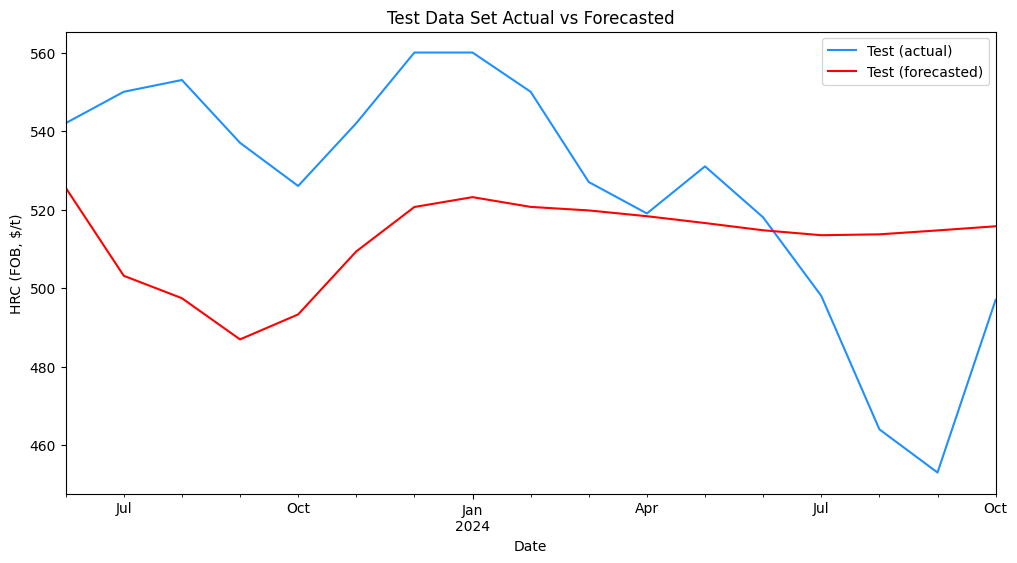

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))

final_df_test['HRC (FOB, $/t)'].plot(color='dodgerblue', label='Test (actual)')
df_forecast1['HRC (FOB, $/t)_forecast'].plot(color='r', label='Test (forecasted)')

plt.title("Test Data Set Actual vs Forecasted")
plt.ylabel("HRC (FOB, $/t)")
plt.xlabel("Date")
ax.legend()

In [17]:
# Error metrics

forecast = df_forecast1['HRC (FOB, $/t)_forecast'].values
actual = final_df_test['HRC (FOB, $/t)']

mae = np.mean(np.abs(forecast - actual))
rmse = np.mean((forecast - actual)**2)**.5
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
print('Mean Absolute Error: ', mae)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Percentage Error: ', mape)

Mean Absolute Error:  30.06518931879021
Root Mean Squared Error:  35.2345898118951
Mean Absolute Percentage Error:  0.0577519457481321


## VAR Model ver 2
using randomly selected variables, splitting into train & test and using train to do the forecasting instead of whole data set

In [18]:
# Read csv
file_path = '../data/final/wo_na_all_cols.csv'
df = pd.read_csv(file_path)

In [19]:
df.head()

,Date,Month,"HRC (FOB, $/t)","Iron Ore (CFR, $/t)","HCC (Aus FOB, $/t)",Domestic Scrap (DDP Jiangsu incl. VAT $/t),RM Cost ($/t),HRC - RM Spread ($/t),CS Production (Mnt),Exports (Mnt),...,Monthly Iron ore Production (Mt.),Stocks of iron ore at China's seaport (Mt.),YTD Growth rate of Investment (FAI),FAI in urban real estate development (y-o-y) Growth,Floor space under construction (y-o-y),Automobile Production (y-o-y),Civil Metal-Vessels/Steel Ships (y-o-y),Household Fridges (y-o-y),Air Conditioner (y-o-y),Manufacturing PMI for steel
0,2006-09-01,Sep-06,472,59,116,252,211,261,36.0,5.0,...,56.50,41.00,27.3,24.3,18.5,24.0,6.0,34.2,3.9,51.7
1,2006-10-01,Oct-06,477,62,85,260,185,292,38.0,5.0,...,56.50,40.77,26.8,24.1,18.8,25.1,11.4,31.8,6.7,55.9
2,2006-11-01,Nov-06,470,62,84,262,182,288,38.0,6.0,...,59.20,37.48,26.6,24.0,18.4,26.1,8.3,28.9,7.2,54.9
3,2006-12-01,Dec-06,470,61,90,270,188,282,39.0,6.0,...,66.70,38.20,24.0,21.8,17.2,27.0,13.1,15.8,16.1,50.1
4,2007-01-01,Jan-07,470,62,98,273,197,273,38.0,5.0,...,69.01,39.80,23.4,24.3,17.2,45.0,8.6,15.8,16.1,55.4


### Section to be replaced by feature selection / granger causality test

For the sake of testing the VAR model, I will select a few stationary variables from the ADF test:

1. RM Cost ($/t)
2. HRC - RM Spread ($/t)
3. Export as % of Production

In [20]:
list_of_variables = ['RM Cost ($/t)', 'HRC - RM Spread ($/t)', 'Export as % of Production']
hrc = ['Date', 'HRC (FOB, $/t)']
final_cols = hrc + list_of_variables

df = df[final_cols]
df.head()

,Date,"HRC (FOB, $/t)",RM Cost ($/t),HRC - RM Spread ($/t),Export as % of Production
0,2006-09-01,472,211,261,14.0
1,2006-10-01,477,185,292,14.0
2,2006-11-01,470,182,288,16.0
3,2006-12-01,470,188,282,15.0
4,2007-01-01,470,197,273,13.0


In [21]:
# Set date column as the index
final_df = df.copy()
final_df.set_index('Date', inplace=True)

final_df.head()

,"HRC (FOB, $/t)",RM Cost ($/t),HRC - RM Spread ($/t),Export as % of Production
Date,,,,
2006-09-01,472,211,261,14.0
2006-10-01,477,185,292,14.0
2006-11-01,470,182,288,16.0
2006-12-01,470,188,282,15.0
2007-01-01,470,197,273,13.0


In [22]:
# Split dataset into train and test set
nobs = 12 #setting the number of forecasted periods to 12 months / 1 year
final_df_train, final_df_test = final_df[0:-nobs], final_df[-nobs:]

print(final_df_train.shape)
print(final_df_test.shape)

(206, 4)
(12, 4)


In [23]:
# Determine the best number of lags
model = VAR(final_df_train)
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,19.34,19.41,2.510e+08,19.37
1,13.86,14.19*,1.041e+06,13.99
2,13.59,14.19,7.962e+05,13.83*
3,13.52,14.40,7.477e+05,13.88
4,13.42*,14.57,6.743e+05*,13.88
5,13.42,14.84,6.778e+05,14.00
6,13.45,15.14,6.988e+05,14.13
7,13.49,15.44,7.282e+05,14.28
8,13.50,15.73,7.423e+05,14.40
9,13.60,16.09,8.216e+05,14.61


In [24]:
# As lag 4 gives the lowest AIC value, to fit it accordingly in the model
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, Mar, 2025
Time:                     11:11:06
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    14.6062
Nobs:                     202.000    HQIC:                   13.9431
Log likelihood:          -2441.24    FPE:                    725109.
AIC:                      13.4925    Det(Omega_mle):         524847.
--------------------------------------------------------------------
Results for equation HRC (FOB, $/t)
                                  coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------
const                               48.575433        13.634221            3.563           0.000
L1.HRC (FOB, $/t)                    8.858517         4.759047            1.861        

In [25]:
# Test if there is any serial correlation in the residuals using the Durbin Watson's Statistic.
# Significant correlation may imply that some pattern in the time series has yet to be captured and may
# require more variables to be included / using a different lag order / using a different model.
# A Durbin Watson value close to 2 implies no significant serial correlation. Values closer to 0 and 4 imply
# positive and negative serial correlation respectively.

out = durbin_watson(model_fitted.resid)

for col, val in zip(final_df.columns, out):
    print(col, ':', round(val, 2))

HRC (FOB, $/t) : 1.96
RM Cost ($/t) : 2.03
HRC - RM Spread ($/t) : 2.05
Export as % of Production : 1.99


In [26]:
# Using the last 4 observations (since lag order is 4) to forecast the following periods
lag_order = model_fitted.k_ar
forecast_input = final_df_train.values[-lag_order:]
forecast_input

array([[550., 412., 138.,   8.],
       [553., 430., 124.,  10.],
       [537., 499.,  38.,  10.],
       [526., 544., -18.,  10.]])

In [27]:
# Forecast the following 29 periods
fc = model_fitted.forecast(y=forecast_input, steps=29)
fc_period = pd.date_range(start='11/1/2023', end='3/1/2026', freq='MS')
df_forecast = pd.DataFrame(fc, index=fc_period, columns=final_df_test.columns + '_f')
df_forecast

,"HRC (FOB, $/t)_f",RM Cost ($/t)_f,HRC - RM Spread ($/t)_f,Export as % of Production_f
2023-11-01,513.684370,514.850000,-1.176817,9.777529
2023-12-01,513.407022,491.262407,22.255166,9.831773
2024-01-01,520.369181,466.409689,53.987365,9.930682
2024-02-01,507.298525,442.022795,65.158173,9.957575
2024-03-01,484.354468,413.510076,70.727038,9.968701
2024-04-01,461.423358,383.043702,78.254726,9.873603
2024-05-01,444.453500,358.542053,85.828752,9.621998
2024-06-01,432.886581,339.518895,93.288773,9.380768
2024-07-01,425.185252,325.206871,99.883966,9.207308
2024-08-01,421.718267,314.060841,107.565444,9.135100


In [28]:
df_forecast1, df_forecast2 = df_forecast[0:-17], df_forecast[-17:]
final_df.index = pd.to_datetime(final_df.index)
final_df_train.index = pd.to_datetime(final_df_train.index)
final_df_test.index = pd.to_datetime(final_df_test.index)

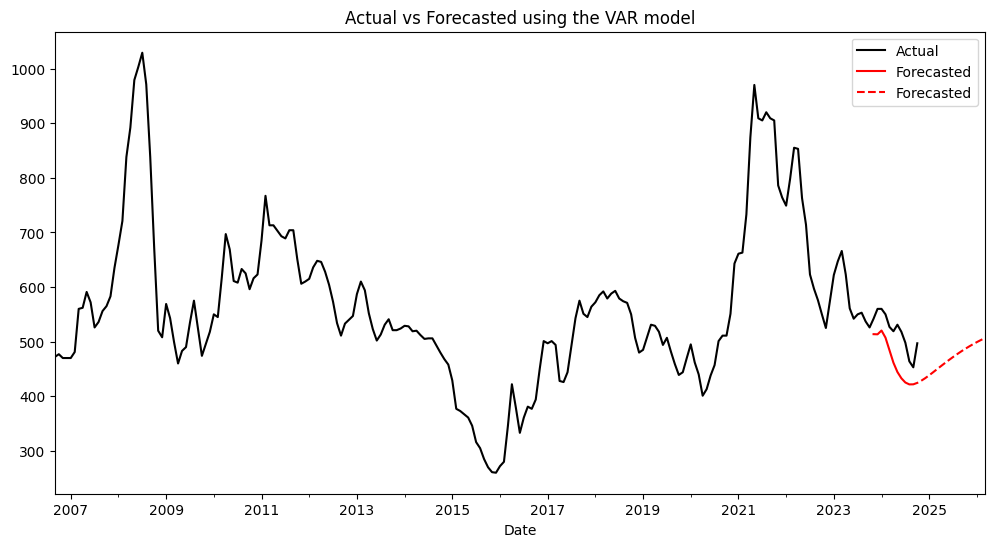

In [29]:
# Compare forecasted with actual results
fig, ax = plt.subplots(figsize=(12, 6))

final_df['HRC (FOB, $/t)'].plot(color='k', label='Actual')
df_forecast1['HRC (FOB, $/t)_f'].plot(color='r', label='Forecasted')
df_forecast2['HRC (FOB, $/t)_f'].plot(color='r', linestyle ='dashed', label='Forecasted')

plt.title('Actual vs Forecasted using the VAR model')
ax.legend()

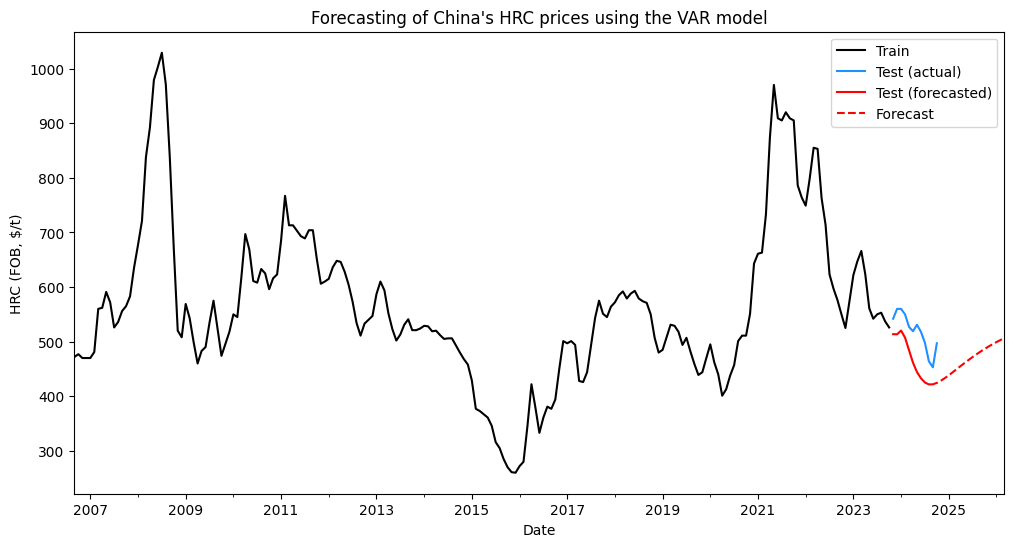

In [30]:
# Compare forecasted with actual results
fig, ax = plt.subplots(figsize=(12, 6))

final_df_train['HRC (FOB, $/t)'].plot(color='k', label='Train')
final_df_test['HRC (FOB, $/t)'].plot(color='dodgerblue', label='Test (actual)')
df_forecast1['HRC (FOB, $/t)_f'].plot(color='r', label='Test (forecasted)')
df_forecast2['HRC (FOB, $/t)_f'].plot(color='r', linestyle ='dashed', label='Forecast')

plt.title("Forecasting of China's HRC prices using the VAR model")
plt.ylabel("HRC (FOB, $/t)")
plt.xlabel("Date")
ax.legend()

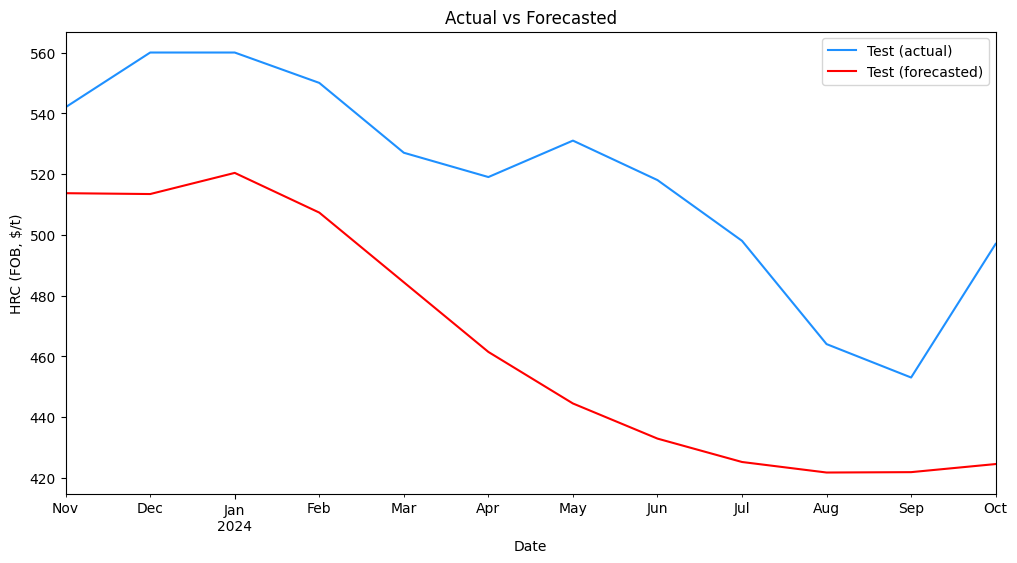

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))

final_df_test['HRC (FOB, $/t)'].plot(color='dodgerblue', label='Test (actual)')
df_forecast1['HRC (FOB, $/t)_f'].plot(color='r', label='Test (forecasted)')

plt.title("Actual vs Forecasted")
plt.ylabel("HRC (FOB, $/t)")
plt.xlabel("Date")
ax.legend()

In [32]:
# Error metrics

forecast = df_forecast1['HRC (FOB, $/t)_f'].values
actual = final_df_test['HRC (FOB, $/t)']

mae = np.mean(np.abs(forecast - actual))
rmse = np.mean((forecast - actual)**2)**.5
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
print('Mean Absolute Error: ', mae)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Percentage Error: ', mape)

Mean Absolute Error:  53.98918327038812
Root Mean Squared Error:  57.40987542672911
Mean Absolute Percentage Error:  0.10458268463533082


### Conclusion
As seen from the graph, the VAR model captured the decreasing trend of the HRC prices. Also, given the relatively low error scores, we can conclude that the VAR model performed decently in forecasting China's HRC export prices.

### Impulse Response Analysis

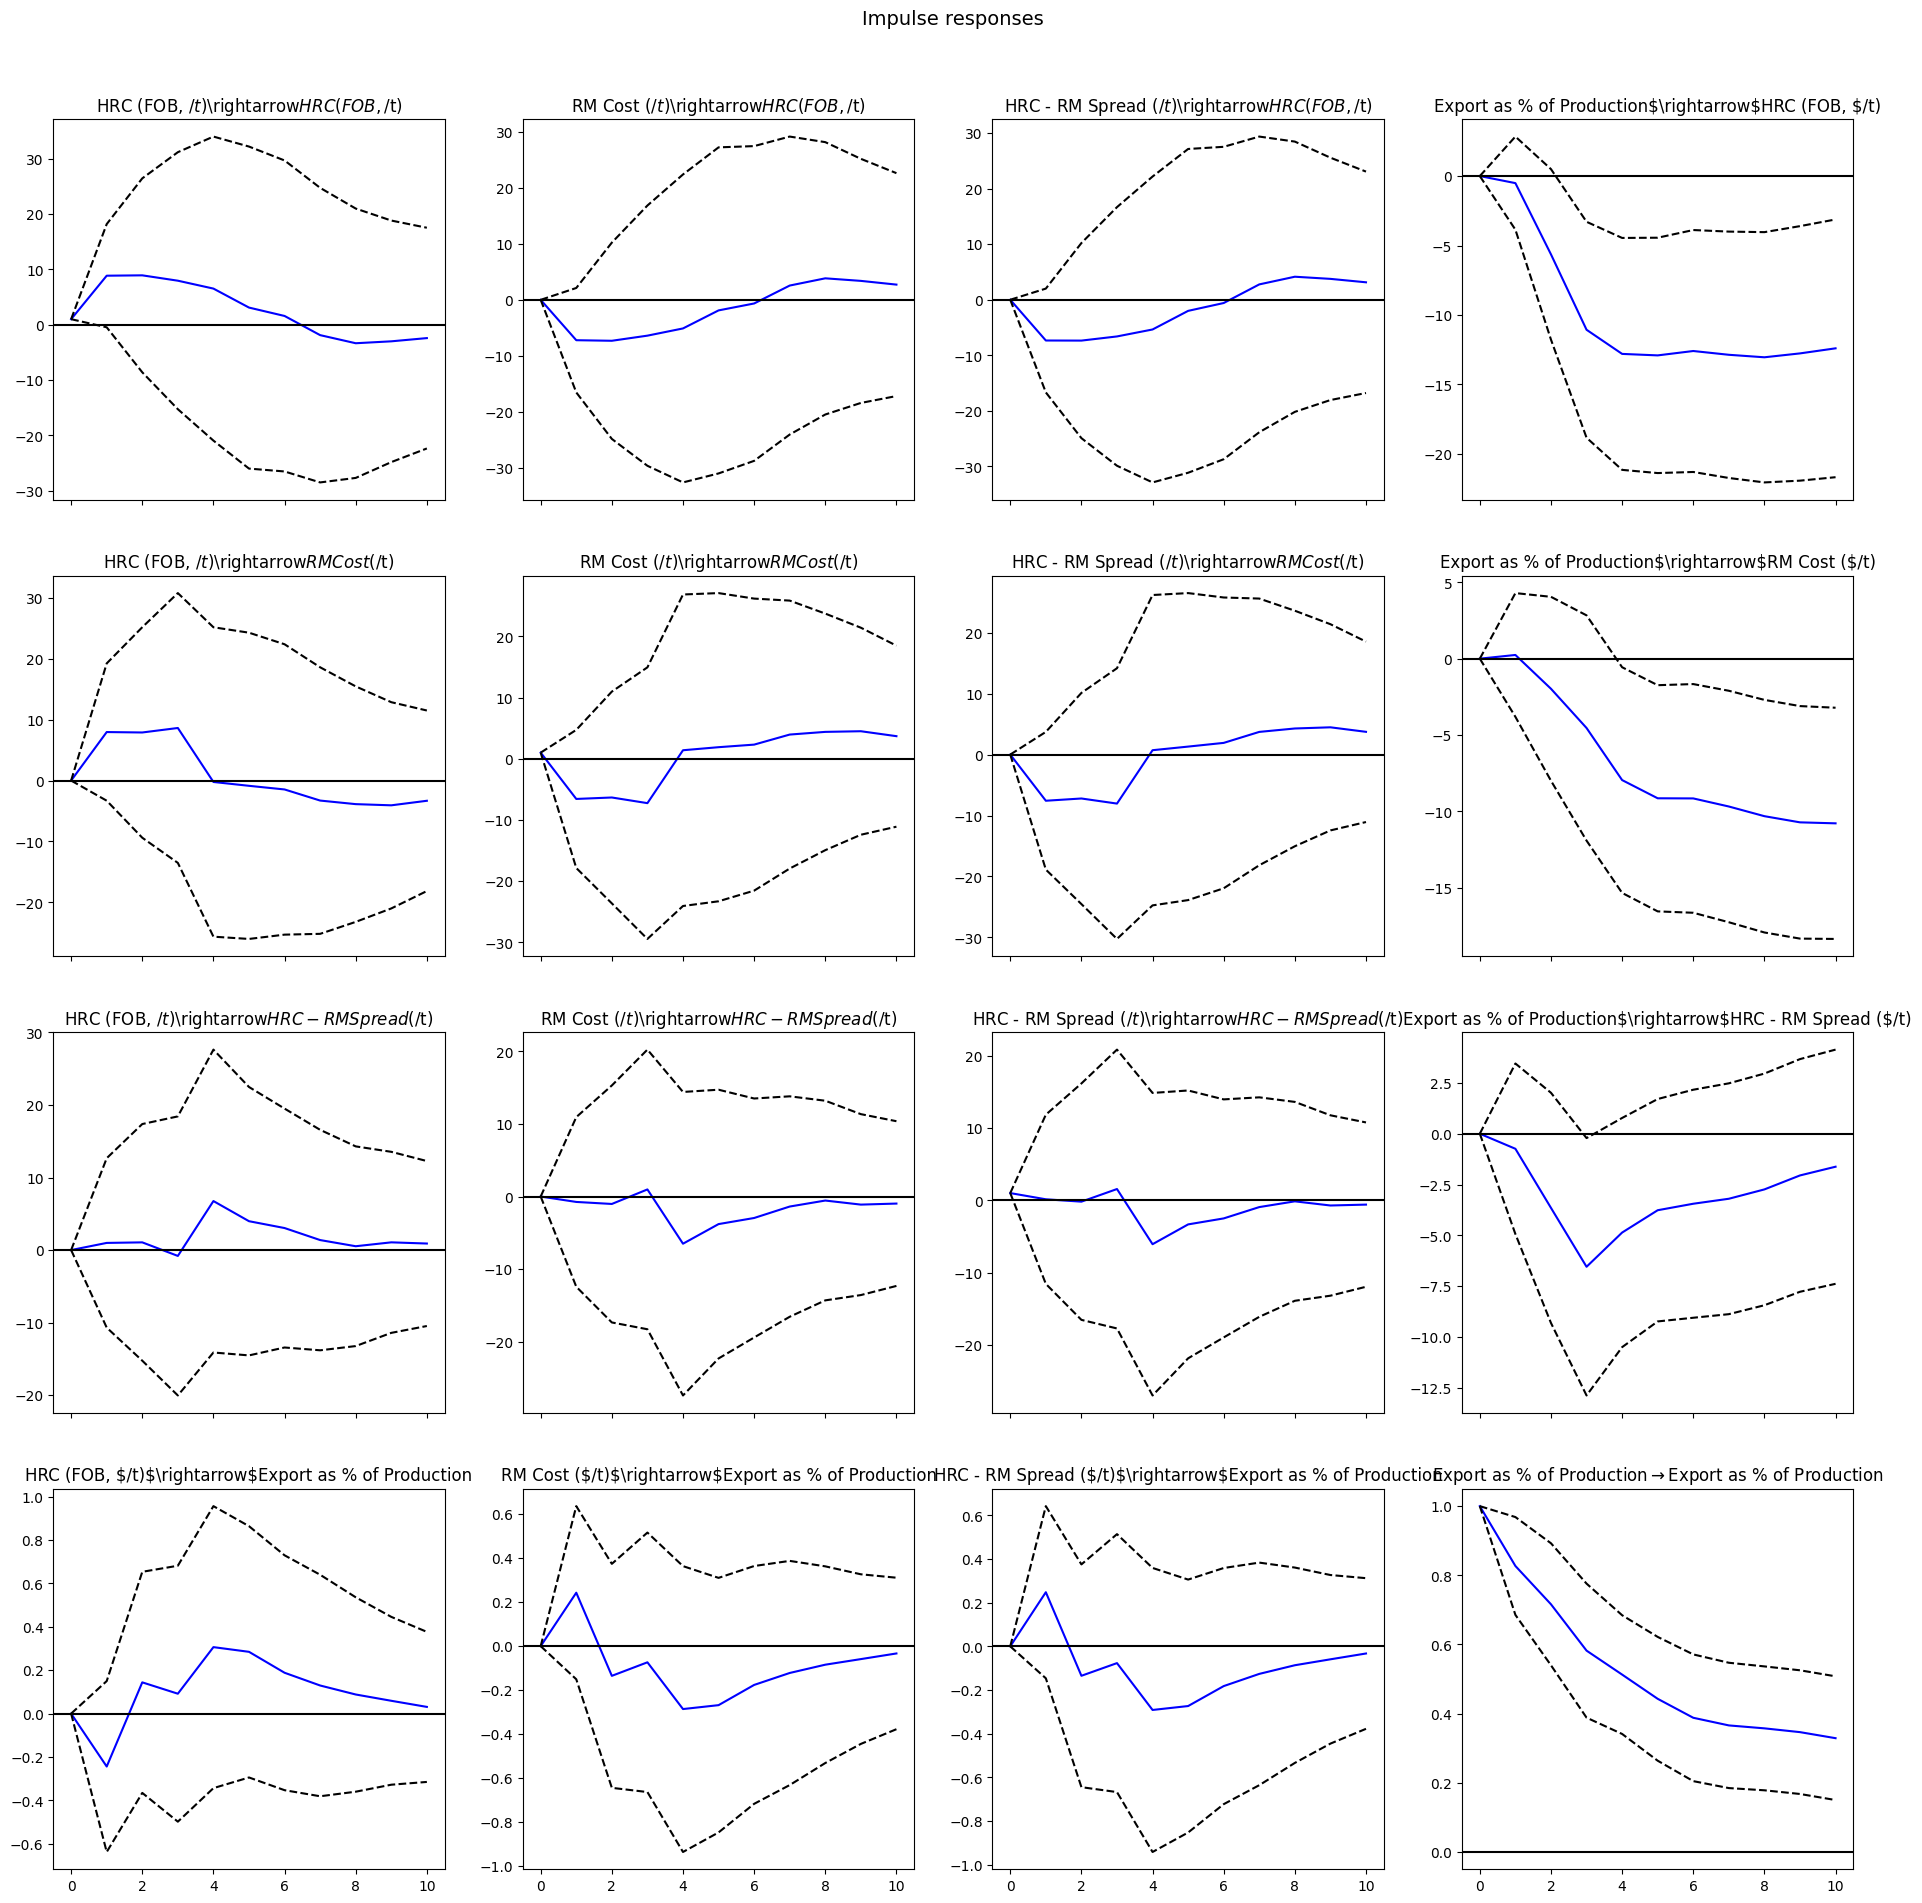

In [33]:
irf = model_fitted.irf(10)
#irf.plot(impulse='RM Cost \n($/t)', response='HRC \n(FOB, $/t)', figsize=(12,6))
irf.plot(figsize=(20,20))
plt.show()

## VAR Model ver 3
using actual variables, using whole data set as train data set to predict the prices

In [34]:
# Read csv
file_path = '../data/final/wo_na.csv'
df = pd.read_csv(file_path)
df.head()

,Date,"HRC (FOB, $/t)","Iron Ore (CFR, $/t)","HCC (Aus FOB, $/t)",Domestic Scrap (DDP Jiangsu incl. VAT $/t),HRC - RM Spread ($/t),Monthly Export of Semis & Finished Steel as % of Production,FAI in urban real estate development (y-o-y) Growth,Automobile Production (y-o-y),Civil Metal-Vessels/Steel Ships (y-o-y),Household Fridges (y-o-y),Air Conditioner (y-o-y)
0,2006-09-01,472,59,116,252,261,14.277778,24.3,24.0,6.0,34.2,3.9
1,2006-10-01,477,62,85,260,292,13.657895,24.1,25.1,11.4,31.8,6.7
2,2006-11-01,470,62,84,262,288,16.078947,24.0,26.1,8.3,28.9,7.2
3,2006-12-01,470,61,90,270,282,15.512821,21.8,27.0,13.1,15.8,16.1
4,2007-01-01,470,62,98,273,273,13.026316,24.3,45.0,8.6,15.8,16.1


In [35]:
final_df = df.copy()
final_df.set_index('Date', inplace=True)

final_df.head()

,"HRC (FOB, $/t)","Iron Ore (CFR, $/t)","HCC (Aus FOB, $/t)",Domestic Scrap (DDP Jiangsu incl. VAT $/t),HRC - RM Spread ($/t),Monthly Export of Semis & Finished Steel as % of Production,FAI in urban real estate development (y-o-y) Growth,Automobile Production (y-o-y),Civil Metal-Vessels/Steel Ships (y-o-y),Household Fridges (y-o-y),Air Conditioner (y-o-y)
Date,,,,,,,,,,,
2006-09-01,472,59,116,252,261,14.277778,24.3,24.0,6.0,34.2,3.9
2006-10-01,477,62,85,260,292,13.657895,24.1,25.1,11.4,31.8,6.7
2006-11-01,470,62,84,262,288,16.078947,24.0,26.1,8.3,28.9,7.2
2006-12-01,470,61,90,270,282,15.512821,21.8,27.0,13.1,15.8,16.1
2007-01-01,470,62,98,273,273,13.026316,24.3,45.0,8.6,15.8,16.1


In [36]:
# Difference data to achieve stationarity
final_df_differenced = final_df.diff().dropna()

In [37]:
# Determine the best number of lags
model = VAR(final_df_differenced)
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,44.65,44.83*,2.464e+19,44.72*
1,44.22,46.36,1.601e+19*,45.08
2,44.26,48.36,1.677e+19,45.91
3,44.47,50.53,2.131e+19,46.92
4,44.58,52.61,2.495e+19,47.83
5,44.81,54.79,3.362e+19,48.84
6,44.91,56.85,4.191e+19,49.74
7,45.29,59.20,7.293e+19,50.92
8,45.53,61.40,1.176e+20,51.95
9,45.60,63.43,1.722e+20,52.81


In [38]:
# Use lag with the lowest AIC
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, Mar, 2025
Time:                     11:11:12
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                    52.2011
Nobs:                     213.000    HQIC:                   47.5465
Log likelihood:          -7557.07    FPE:                2.03720e+19
AIC:                      44.3896    Det(Omega_mle):     2.47396e+18
--------------------------------------------------------------------
Results for equation HRC (FOB, $/t)
                                                                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------------------------------------
const                                                                  0.739229         1.813142            0.408  

In [39]:
# Test if there is any serial correlation in the residuals using the Durbin Watson's Statistic.
# Significant correlation may imply that some pattern in the time series has yet to be captured and may
# require more variables to be included / using a different lag order / using a different model.
# A Durbin Watson value close to 2 implies no significant serial correlation. Values closer to 0 and 4 imply
# positive and negative serial correlation respectively.

out = durbin_watson(model_fitted.resid)

for col, val in zip(final_df.columns, out):
    print(col, ':', round(val, 2))

HRC (FOB, $/t) : 1.99
Iron Ore (CFR, $/t) : 2.01
HCC (Aus FOB, $/t) : 2.02
Domestic Scrap (DDP Jiangsu incl. VAT $/t) : 2.04
HRC - RM Spread ($/t) : 2.04
Monthly Export of Semis & Finished Steel as % of Production : 2.03
FAI in urban real estate development (y-o-y) Growth : 1.93
Automobile Production (y-o-y) : 1.95
Civil Metal-Vessels/Steel Ships (y-o-y) : 2.0
Household Fridges (y-o-y) : 1.99
Air Conditioner (y-o-y) : 1.98


In [40]:
# Using the last _ observations (since lag order is _) to forecast the following periods
lag_order = model_fitted.k_ar
forecast_input = final_df_differenced.values[-lag_order:]
forecast_input

array([[-20.        ,  -1.        , -12.        ,  -2.        ,
         -6.        ,  -0.07713463,  -0.1       ,  -1.2       ,
          0.1       ,  -2.4       ,  -4.3       ],
       [-34.        ,  -7.        , -31.        , -30.        ,
          8.        ,   2.74575224,   0.        ,  -1.1       ,
         -0.3       ,   0.        ,  -1.7       ],
       [-11.        ,  -5.        , -19.        ,  -9.        ,
         16.        ,   1.002331  ,   0.1       ,  -0.7       ,
          0.        ,   0.2       ,   0.2       ],
       [ 44.        ,  10.        ,  17.        ,  17.        ,
         11.        ,   0.45232816,  -0.2       ,   0.3       ,
          0.2       ,   1.        ,   0.2       ]])

In [41]:
# Forecast the following 12 periods (length of test set)
fc = model_fitted.forecast(y=forecast_input, steps=17)
fc_period = pd.date_range(start='11/1/2024', end='3/1/2026', freq='MS')
df_forecast = pd.DataFrame(fc, index=fc_period, columns=final_df.columns + '_1d')
df_forecast

,"HRC (FOB, $/t)_1d","Iron Ore (CFR, $/t)_1d","HCC (Aus FOB, $/t)_1d",Domestic Scrap (DDP Jiangsu incl. VAT $/t)_1d,HRC - RM Spread ($/t)_1d,Monthly Export of Semis & Finished Steel as % of Production_1d,FAI in urban real estate development (y-o-y) Growth_1d,Automobile Production (y-o-y)_1d,Civil Metal-Vessels/Steel Ships (y-o-y)_1d,Household Fridges (y-o-y)_1d,Air Conditioner (y-o-y)_1d
2024-11-01,20.629309,2.364135,30.606483,-2.095533,-13.850191,-0.240211,2.312848,6.909955,-0.237175,3.335110,3.012363
2024-12-01,3.183629,0.756695,18.141636,3.016373,-16.268366,-0.266579,1.011927,2.975016,2.456900,1.220875,1.872752
2025-01-01,8.158597,2.134464,-2.464243,10.600086,7.196443,0.265099,-1.075465,-2.072225,-0.255907,-2.098807,-0.707824
2025-02-01,12.827367,2.514066,-7.826123,3.291034,16.726751,0.428827,-0.305621,-1.981106,-1.334121,-0.927459,-0.257606
2025-03-01,7.637114,3.401677,1.739465,1.878800,0.542324,0.220440,0.164124,0.410519,0.590534,0.871490,0.888513
2025-04-01,-2.249667,-0.552508,3.032983,-3.336587,-4.439723,-0.029160,0.200496,0.105462,0.810661,0.196828,0.685868
2025-05-01,-5.558351,-2.557431,0.226096,-3.830762,-1.728715,-0.202938,0.182532,-0.209631,0.459154,-0.440417,-0.085983
2025-06-01,-1.823958,-1.597611,-1.359309,0.237479,2.113568,-0.067968,-0.379584,-0.774145,-0.996796,-0.609911,-0.380049
2025-07-01,0.394816,0.108253,-1.989427,1.250267,2.258856,0.059567,-0.428865,-1.004499,-0.728719,-0.341489,-0.380746
2025-08-01,0.041512,0.636509,0.703261,0.752172,-1.701948,0.027693,-0.234788,-0.052766,0.056361,0.231621,-0.031420


In [42]:
# De-difference forecasted results
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_forecast_processed = invert_transformation(final_df, df_forecast)
df_forecast_processed

,"HRC (FOB, $/t)_1d","Iron Ore (CFR, $/t)_1d","HCC (Aus FOB, $/t)_1d",Domestic Scrap (DDP Jiangsu incl. VAT $/t)_1d,HRC - RM Spread ($/t)_1d,Monthly Export of Semis & Finished Steel as % of Production_1d,FAI in urban real estate development (y-o-y) Growth_1d,Automobile Production (y-o-y)_1d,Civil Metal-Vessels/Steel Ships (y-o-y)_1d,Household Fridges (y-o-y)_1d,...,"Iron Ore (CFR, $/t)_forecast","HCC (Aus FOB, $/t)_forecast",Domestic Scrap (DDP Jiangsu incl. VAT $/t)_forecast,HRC - RM Spread ($/t)_forecast,Monthly Export of Semis & Finished Steel as % of Production_forecast,FAI in urban real estate development (y-o-y) Growth_forecast,Automobile Production (y-o-y)_forecast,Civil Metal-Vessels/Steel Ships (y-o-y)_forecast,Household Fridges (y-o-y)_forecast,Air Conditioner (y-o-y)_forecast
2024-11-01,20.629309,2.364135,30.606483,-2.095533,-13.850191,-0.240211,2.312848,6.909955,-0.237175,3.335110,...,106.364135,234.606483,351.904467,113.149809,13.393935,-7.987152,9.909955,1.062825,11.835110,11.212363
2024-12-01,3.183629,0.756695,18.141636,3.016373,-16.268366,-0.266579,1.011927,2.975016,2.456900,1.220875,...,107.120830,252.748119,354.920840,96.881442,13.127356,-6.975225,12.884971,3.519725,13.055985,13.085115
2025-01-01,8.158597,2.134464,-2.464243,10.600086,7.196443,0.265099,-1.075465,-2.072225,-0.255907,-2.098807,...,109.255295,250.283876,365.520926,104.077886,13.392455,-8.050690,10.812746,3.263818,10.957178,12.377291
2025-02-01,12.827367,2.514066,-7.826123,3.291034,16.726751,0.428827,-0.305621,-1.981106,-1.334121,-0.927459,...,111.769360,242.457754,368.811959,120.804637,13.821283,-8.356311,8.831641,1.929697,10.029718,12.119685
2025-03-01,7.637114,3.401677,1.739465,1.878800,0.542324,0.220440,0.164124,0.410519,0.590534,0.871490,...,115.171038,244.197219,370.690759,121.346960,14.041723,-8.192186,9.242159,2.520230,10.901208,13.008198
2025-04-01,-2.249667,-0.552508,3.032983,-3.336587,-4.439723,-0.029160,0.200496,0.105462,0.810661,0.196828,...,114.618530,247.230202,367.354172,116.907238,14.012563,-7.991691,9.347622,3.330891,11.098037,13.694066
2025-05-01,-5.558351,-2.557431,0.226096,-3.830762,-1.728715,-0.202938,0.182532,-0.209631,0.459154,-0.440417,...,112.061099,247.456298,363.523410,115.178522,13.809625,-7.809159,9.137991,3.790045,10.657619,13.608084
2025-06-01,-1.823958,-1.597611,-1.359309,0.237479,2.113568,-0.067968,-0.379584,-0.774145,-0.996796,-0.609911,...,110.463488,246.096988,363.760888,117.292090,13.741656,-8.188743,8.363846,2.793249,10.047709,13.228035
2025-07-01,0.394816,0.108253,-1.989427,1.250267,2.258856,0.059567,-0.428865,-1.004499,-0.728719,-0.341489,...,110.571741,244.107561,365.011155,119.550946,13.801224,-8.617608,7.359347,2.064530,9.706220,12.847289
2025-08-01,0.041512,0.636509,0.703261,0.752172,-1.701948,0.027693,-0.234788,-0.052766,0.056361,0.231621,...,111.208250,244.810821,365.763328,117.848998,13.828916,-8.852396,7.306581,2.120891,9.937841,12.815869


In [43]:
final_df.index = pd.to_datetime(final_df.index)

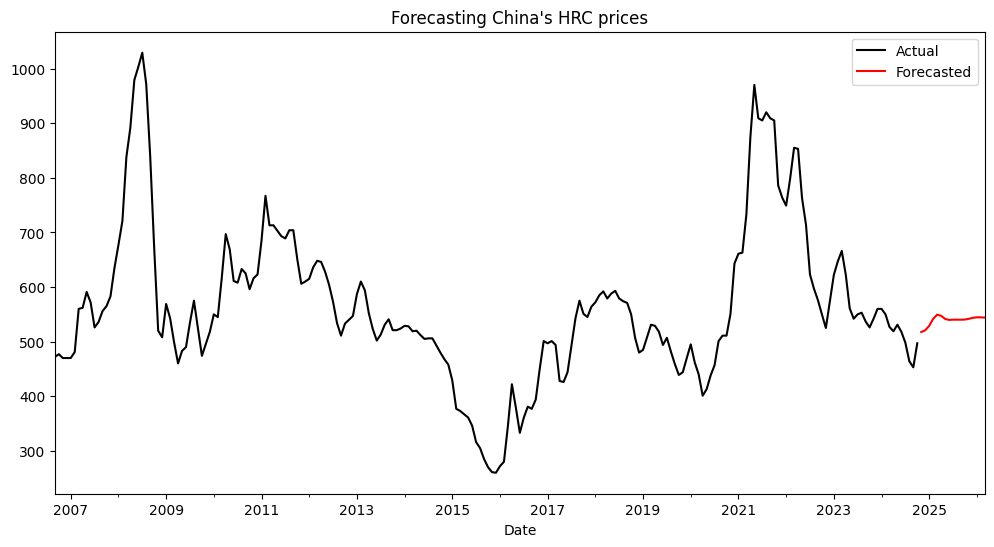

In [44]:
# Compare forecasted with actual results
fig, ax = plt.subplots(figsize=(12, 6))

final_df['HRC (FOB, $/t)'].plot(color='k', label='Actual')
df_forecast_processed['HRC (FOB, $/t)_forecast'].plot(color='r', label='Forecasted')

plt.title("Forecasting China's HRC prices")
ax.legend()

In [45]:
'''
## VAR Model ver 2
# Read csv
file_path = '../data/final/wo_na.csv'
df = pd.read_csv(file_path)
df.head()
### Section to be replaced by feature selection / granger causality test

For the sake of testing the VAR model, I will select a few stationary variables from the ADF test:

1. RM Cost ($/t)
2. HRC - RM Spread ($/t)
3. Export as % of Production
list_of_variables = ['RM Cost \n($/t)', 'HRC - RM \nSpread ($/t)', 'Export as % of Production']
hrc = ['Month_Dt', 'HRC \n(FOB, $/t)']
final_cols = hrc + list_of_variables

df = df[final_cols]
df.head()
# Set date column as the index
final_df = df.copy()
final_df = final_df.rename(columns={'Month_Dt':'Date'})
final_df.set_index('Date', inplace=True)

final_df.head()
# Split dataset into train and test set
nobs = 12 #setting the number of forecasted periods to 12 months / 1 year
final_df_train, final_df_test = final_df[0:-nobs], final_df[-nobs:]

print(final_df_train.shape)
print(final_df_test.shape)
# Determine the best number of lags
model = VAR(final_df_train)
x = model.select_order(maxlags=12)
x.summary()
# As lag 4 gives the lowest AIC value, to fit it accordingly in the model
model_fitted = model.fit(4)
model_fitted.summary()
# Test if there is any serial correlation in the residuals using the Durbin Watson's Statistic.
# Significant correlation may imply that some pattern in the time series has yet to be captured and may
# require more variables to be included / using a different lag order / using a different model.
# A Durbin Watson value close to 2 implies no significant serial correlation. Values closer to 0 and 4 imply
# positive and negative serial correlation respectively.

out = durbin_watson(model_fitted.resid)

for col, val in zip(final_df.columns, out):
    print(col, ':', round(val, 2))
# Using the last 4 observations (since lag order is 4) to forecast the following periods
lag_order = model_fitted.k_ar
forecast_input = final_df_train.values[-lag_order:]
forecast_input
# Forecast the following 12 periods (length of test set)
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=final_df_test.index, columns=final_df_test.columns + '_f')
df_forecast
# Compare forecasted with actual results
fig, ax = plt.subplots(figsize=(12, 6))

final_df_test['HRC \n(FOB, $/t)'].plot(color='k', label='Actual')
df_forecast['HRC \n(FOB, $/t)_f'].plot(color='r', label='Forecasted')

plt.title('Actual vs Forecasted using the VAR model')
ax.legend()
# Error metrics

forecast = df_forecast['HRC \n(FOB, $/t)_f'].values
actual = final_df_test['HRC \n(FOB, $/t)']

mae = np.mean(np.abs(forecast - actual))
rmse = np.mean((forecast - actual)**2)**.5
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
print('Mean Absolute Error: ', mae)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Percentage Error: ', mape)
### Conclusion
As seen from the graph, the VAR model captured the decreasing trend of the HRC prices. Also, given the relatively low error scores, we can conclude that the VAR model performed decently in forecasting China's HRC export prices.
### Impulse Response Analysis
irf = model_fitted.irf(10)
#irf.plot(impulse='RM Cost \n($/t)', response='HRC \n(FOB, $/t)', figsize=(12,6))
irf.plot(figsize=(20,20))
plt.show()
'''

"\n## VAR Model ver 2\n# Read csv\nfile_path = '../data/final/wo_na.csv'\ndf = pd.read_csv(file_path)\ndf.head()\n### Section to be replaced by feature selection / granger causality test\n\nFor the sake of testing the VAR model, I will select a few stationary variables from the ADF test:\n\n1. RM Cost ($/t)\n2. HRC - RM Spread ($/t)\n3. Export as % of Production\nlist_of_variables = ['RM Cost \n($/t)', 'HRC - RM \nSpread ($/t)', 'Export as % of Production']\nhrc = ['Month_Dt', 'HRC \n(FOB, $/t)']\nfinal_cols = hrc + list_of_variables\n\ndf = df[final_cols]\ndf.head()\n# Set date column as the index\nfinal_df = df.copy()\nfinal_df = final_df.rename(columns={'Month_Dt':'Date'})\nfinal_df.set_index('Date', inplace=True)\n\nfinal_df.head()\n# Split dataset into train and test set\nnobs = 12 #setting the number of forecasted periods to 12 months / 1 year\nfinal_df_train, final_df_test = final_df[0:-nobs], final_df[-nobs:]\n\nprint(final_df_train.shape)\nprint(final_df_test.shape)\n# Determi